In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from threadpoolctl import threadpool_limits


In [3]:
# Loading the datasets:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [4]:
customer_profiles = transactions.groupby('CustomerID').agg({    # Merging customer profile information with transaction summaries
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()
customer_profiles = customer_profiles.merge(customers, on='CustomerID', how='left')


In [5]:
# Standardizing the data for clustering:
scaler = StandardScaler()
profile_features = ['Quantity', 'TotalValue']
customer_profiles[profile_features] = scaler.fit_transform(customer_profiles[profile_features])

In [6]:
# Function to run KMeans for different k and computing DB Index:
def evaluate_kmeans(data, k_values):
    results = []
    for k in k_values:
        with threadpool_limits(limits=1, user_api='blas'):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(data)

        # Calculate Davies-Bouldin Index
        db_index = davies_bouldin_score(data, labels)

        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(data, labels)

        results.append({
            'k': k,
            'DB_Index': db_index,
            'Silhouette_Score': silhouette_avg,
            'Labels': labels
        })
    return results

In [9]:
k_values = range(2, 11)
kmeans_results = evaluate_kmeans(customer_profiles[profile_features], k_values)
best_result = min(kmeans_results, key=lambda x: x['DB_Index'])
best_k = best_result['k']
best_labels = best_result['Labels']
best_db_index = best_result['DB_Index']
best_silhouette = best_result['Silhouette_Score']

Best k: 2
Davies-Bouldin Index: 0.63
Silhouette Score: 0.55


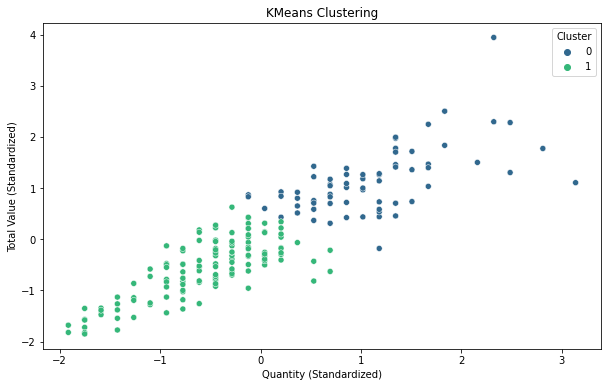

In [10]:
customer_profiles['KMeans_Cluster'] = best_labels
print(f"Best k: {best_k}")
print(f"Davies-Bouldin Index: {best_db_index:.2f}")
print(f"Silhouette Score: {best_silhouette:.2f}")

# Visualizing the Clusters:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_profiles['Quantity'],
    y=customer_profiles['TotalValue'],
    hue=customer_profiles['KMeans_Cluster'],
    palette='viridis',
    legend='full'
)
plt.title('KMeans Clustering')
plt.xlabel('Quantity (Standardized)')
plt.ylabel('Total Value (Standardized)')
plt.legend(title='Cluster')
plt.show()

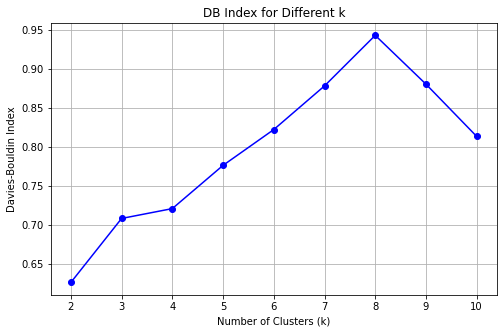

In [11]:
# Plotting DB Index for different k values:
db_indices = [result['DB_Index'] for result in kmeans_results]
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_indices, marker='o', linestyle='-', color='b')
plt.title('DB Index for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()
plt.show()

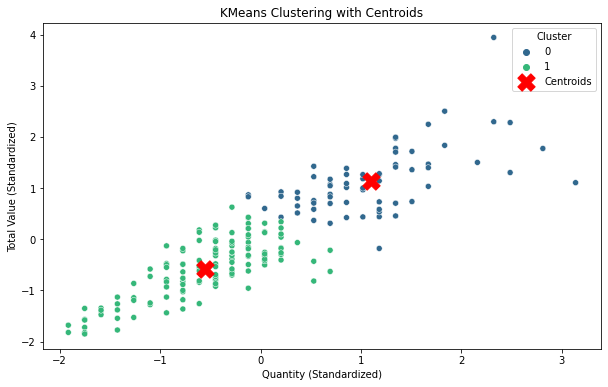

In [12]:
# Visualizing Cluster Centroids:
best_kmeans = KMeans(n_clusters=best_k, random_state=42).fit(customer_profiles[profile_features])
centroids = best_kmeans.cluster_centers_
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_profiles['Quantity'],
    y=customer_profiles['TotalValue'],
    hue=customer_profiles['KMeans_Cluster'],
    palette='viridis',
    legend='full'
)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroids', marker='X')
plt.title('KMeans Clustering with Centroids')
plt.xlabel('Quantity (Standardized)')
plt.ylabel('Total Value (Standardized)')
plt.legend(title='Cluster')
plt.show()



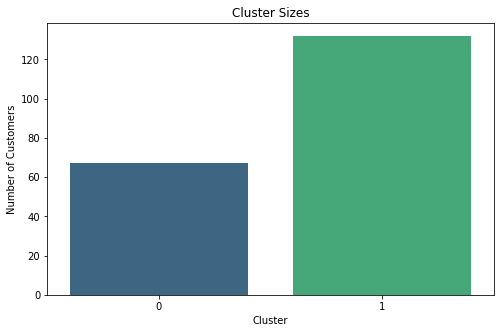

In [13]:
# Visualizing the Cluster Sizes
plt.figure(figsize=(8, 5))
sns.countplot(x='KMeans_Cluster', data=customer_profiles, palette='viridis')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()